In [ ]:
# import data from drive

from google.colab import drive
drive.mount('/content/gdrive')

!unzip -q "/content/gdrive/My Drive/Data.zip"

In [ ]:
'''

project : Covid-19-detection-using-Xray
Author : @kanishksh4rma

'''

In [6]:
from imutils import paths
import matplotlib.pyplot as plt
import argparse
import os

In [7]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.layers import AveragePooling2D, Dropout,Flatten,Dense,Input
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

In [9]:
dataset = "/content/Data"
args={}
args["dataset"]=dataset

In [10]:
import numpy as np
import cv2
img_paths = list(paths.list_images(args["dataset"]))  #image paths
data = []
labels = []
for path in img_paths:
    label = path.split(os.path.sep)[-2]   #split the image paths
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #Convert images into RGB Channel
    image = cv2.resize(image, (224, 224))  #Resizing the images
    data.append(image)
    labels.append(label)
data = np.array(data) / 255.0
labels = np.array(labels)

In [11]:
Data_Dir = "Data//"

In [12]:
Cimages = os.listdir(Data_Dir+"Covid")
Nimages = os.listdir(Data_Dir+"Normal")

Normal Chest X-ray Vs Covid-19 Chest X-ray


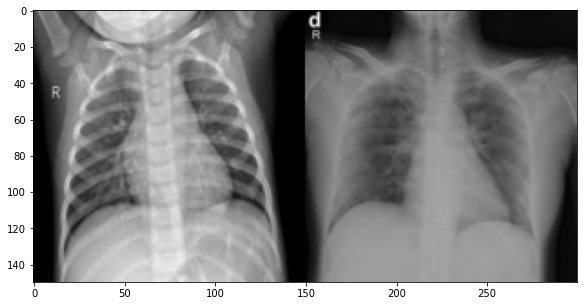

Normal Chest X-ray Vs Covid-19 Chest X-ray


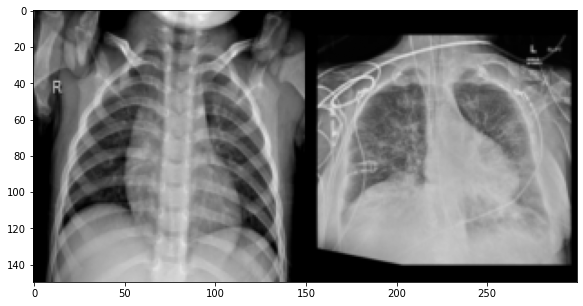

Normal Chest X-ray Vs Covid-19 Chest X-ray


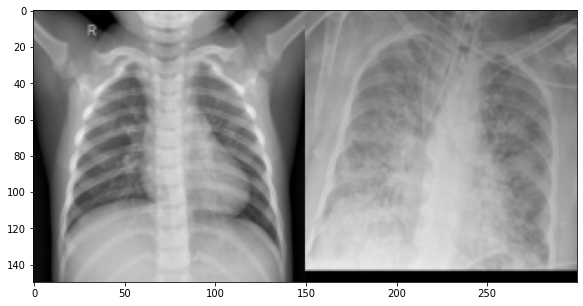

Normal Chest X-ray Vs Covid-19 Chest X-ray


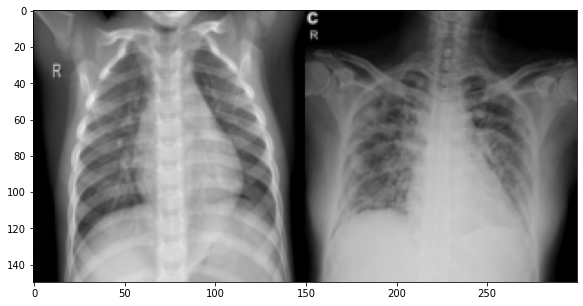

Normal Chest X-ray Vs Covid-19 Chest X-ray


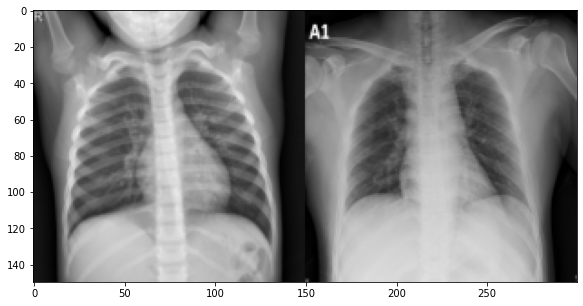

In [13]:
import matplotlib.pyplot as plt
import cv2
import skimage
from skimage.transform import resize
import numpy as np
def plotter(i):
    normal = cv2.imread(Data_Dir+"Normal//"+Nimages[i])
    normal = skimage.transform.resize(normal, (150, 150, 3))
    coronavirus = cv2.imread(Data_Dir+"Covid//"+Cimages[i])
    coronavirus = skimage.transform.resize(coronavirus, (150, 150, 3) , mode = 'reflect')
    pair = np.concatenate((normal, coronavirus), axis=1)
    print("Normal Chest X-ray Vs Covid-19 Chest X-ray")
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()
for i in range(0,5):
    plotter(i)

In [14]:
LB = LabelBinarizer()  
#Initialize label binarizer
labels = LB.fit_transform(labels)
labels = to_categorical(labels)

In [15]:
# test train split
(X_train, X_test, Y_train, Y_test) = train_test_split(data, labels,
    test_size=0.20, stratify=labels, random_state=42)

In [16]:
#rotate images to create more data
trainAug = ImageDataGenerator(
    rotation_range=15,
    fill_mode="nearest")

In [17]:
bModel = VGG16(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))  #base_Model
hModel = bModel.output #head_Model
hModel = AveragePooling2D(pool_size=(4, 4))(hModel)
hModel = Flatten(name="flatten")(hModel)
hModel = Dense(64, activation="relu")(hModel)
hModel = Dropout(0.5)(hModel)
hModel = Dense(2, activation="softmax")(hModel)
model = Model(inputs=bModel.input, outputs=hModel)

for layer in bModel.layers:
    layer.trainable = False

58892288/58889256 [==============================] - 0s 0us/step


In [18]:
X_train.shape,X_test.shape,Y_train.shape,Y_test.shape

((160, 224, 224, 3), (40, 224, 224, 3), (160, 2), (40, 2))

In [8]:
INIT_LR = 1e-3
EPOCHS = 10
BS = 8

In [19]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

R = model.fit_generator(
    trainAug.flow(X_train, Y_train, batch_size=BS),
    steps_per_epoch=len(X_train) // BS,
    validation_data=(X_test, Y_test),
    validation_steps=len(X_test) // BS,
    epochs=EPOCHS)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
20/20 [==============================] - 98s 5s/step - loss: 0.7569 - accuracy: 0.4938 - val_loss: 0.4968 - val_accuracy: 0.8250
Epoch 2/10
20/20 [==============================] - 98s 5s/step - loss: 0.5232 - accuracy: 0.8000 - val_loss: 0.3614 - val_accuracy: 1.0000
Epoch 3/10
20/20 [==============================] - 98s 5s/step - loss: 0.3637 - accuracy: 0.9187 - val_loss: 0.2485 - val_accuracy: 0.9750
Epoch 4/10
20/20 [==============================] - 97s 5s/step - loss: 0.2749 - accuracy: 0.9438 - val_loss: 0.2106 - val_accuracy: 0.9500
Epoch 5/10
20/20 [==============================] - 97s 5s/step - loss: 0.2465 - accuracy: 0.9563 - val_loss: 0.1376 - val_accuracy: 0.9750
Epoch 6/10
20/20 [==============================] - 98s 5s/step - loss: 0.1843 - accuracy: 0.9500 - val_loss: 0.1078 - val_accuracy: 1.0000
Epoch 7/10
20/20 [==============================] - 97s 5s/step - loss: 0.1762 - acc

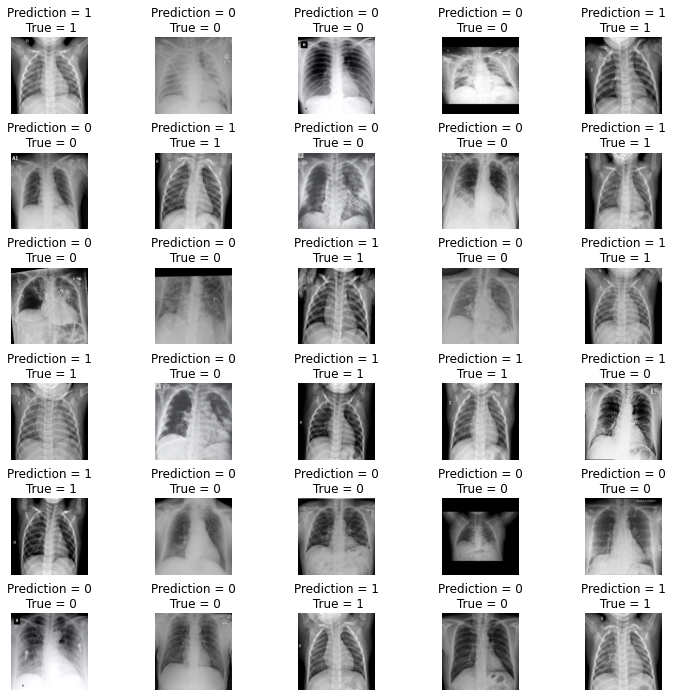

In [20]:
L = 6
W = 5
fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()
y_pred = model.predict(X_test, batch_size=BS)
for i in np.arange(0,L*W):
    axes[i].imshow(X_test[i])
    axes[i].set_title('Prediction = {}\n True = {}'.format(y_pred.argmax(axis=1)[i], Y_test.argmax(axis=1)[i]))
    axes[i].axis('off')

plt.subplots_adjust(wspace = 0.5, hspace=0.5)   

In [21]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_test, batch_size=BS)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(Y_test.argmax(axis=1), y_pred,target_names=LB.classes_))

              precision    recall  f1-score   support

       Covid       1.00      0.95      0.97        20
      Normal       0.95      1.00      0.98        20

    accuracy                           0.97        40
   macro avg       0.98      0.97      0.97        40
weighted avg       0.98      0.97      0.97        40



In [27]:
from sklearn.metrics import accuracy_score
print('Accuracy score : ',accuracy_score(Y_test.argmax(axis=1),y_pred)*100,'%')

Accuracy score :  97.5 %


In [28]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test.argmax(axis=1), y_pred)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[19  1]
 [ 0 20]]
acc: 0.9750
sensitivity: 0.9500
specificity: 1.0000


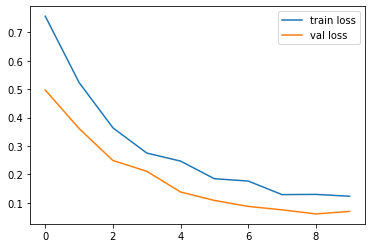

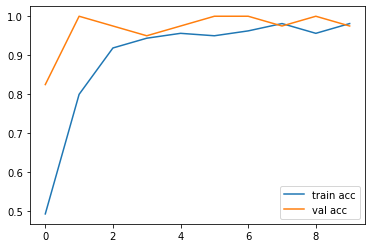

In [29]:
# plot the loss
plt.plot(R.history['loss'], label='train loss')
plt.plot(R.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(R.history['accuracy'], label='train acc')
plt.plot(R.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [30]:
model.save('Covid_model.h5')

Prediction: Normal


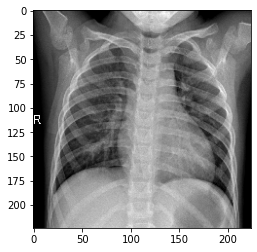

In [43]:
img = image.load_img('Data/Normal/IM-0162-0001.jpeg', target_size=(224, 224)) #insert a random normal x-ray image
imgplot = plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
img_data = preprocess_input(x)
classes = model.predict(img_data)
New_pred = np.argmax(classes, axis=1)
if New_pred==[1]:
  print('Prediction: Normal')
else:
  print('Prediction: Corona')